In [1]:
#Global Imports
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy

# Load Data from Bugzilla (REST)

Here's a link to the [Bugzilla URL for Papyrus](https://bugs.eclipse.org/bugs/buglist.cgi?bug_status=UNCONFIRMED&bug_status=NEW&bug_status=ASSIGNED&bug_status=REOPENED&limit=0&list_id=17376363&order=priority%2Cbug_severity&product=Papyrus&query_format=advanced) (filtered on open bugs):

First we need to request the data based on our Bugzilla query. The initial response will only include overall bug information, so to retrieve the full bug text (with comments), an additional request is made for each bug.

We'll create a few arrays of data based on the bugs:
1. bug_ids - the text id of the bug
2. bug_titles - the title of the bug
3. bug_products - the product listed for the bug
4. bug_components - the component listed for the bug
5. bug_text - a concatenation of all of the text (including comments) entered for the bug

# REST Data Loading

This piece loads JSON formated data through a http GET request and parses it into the arrays described previously.

In [ ]:
import requests

# Remove the limit=10 after debugging errors. Beware of rate limits. Eclipse Bugzilla automatically limits to 2000
resp = requests.get('https://bugs.eclipse.org/bugs/rest/bug?limit=10&product=Papyrus&bug_status=UNCONFIRMED&bug_status=NEW&bug_status=ASSIGNED&bug_status=REOPENED')
if resp.status_code != 200:
    # This means something went wrong.
    raise ApiError('GET /tasks/ {}'.format(resp.status_code))

bugs = resp.json()
print('Loaded '+str(len(bugs['bugs']))+' bugs')


bug_ids = []
bug_titles = []
bug_products = []
bug_components = []
bug_text = []

def getComments(id):
    url = 'https://bugs.eclipse.org/bugs/rest/bug/'+str(id)+'/comment'
    resp = requests.get(url)
    if resp.status_code != 200:
        # This means something went wrong.
        raise ApiError('GET /tasks/ {}'.format(resp.status_code))
    response = resp.json()
    
    text = ' '
    for comment in response['bugs'][str(id)]['comments']:
        text += ' '+ comment['text']
    return text
    
for bug in bugs['bugs']:
    id = bug['id']
    bug_ids.append(id)
    
    summary = bug['summary']
    bug_titles.append(summary)
    product = bug['product']
    bug_products.append(product)
    
    component = bug['component']
    bug_components.append(component)
    
    text = summary + getComments(id)
    bug_text.append(text);    


# XML Data Loading

Another approach is to download an XML file from a Bugzilla query so that you don't have to connect to the server every time you run this notebook. It is good for debugging, but will need to switch back to a live connection any time you want to pick up new data.

In [2]:
import xml.etree.ElementTree as ET

bug_ids = []
bug_titles = []
bug_products = []
bug_components = []
bug_text = []

filename = 'path-to-your-file.xml'
tree = ET.parse(filename)
root = tree.getroot()
for bug in root:
    
    id = bug.find('bug_id')
    bug_ids.append(id.text)
    
    title = bug.find('short_desc')
    bug_titles.append(title.text)
    
    product = bug.find('product')
    bug_products.append(product.text)
    
    component = bug.find('component')
    bug_components.append(component.text)
    
    text = title.text
    for thetext in bug.iter('thetext'):
        if thetext.text:
            text += ' '+ thetext.text
    for longdesc in bug.iter('long_desc'):
        thetext = longdesc.find('thetext')
        if thetext.text:
            text += ' '+ thetext.text
    bug_text.append(text);    
    
print('Loaded '+str(len(bug_ids))+' bugs')

Loaded 2000 bugs


# Create a Tokenize Method
This method provides a simple list of words from the text. We will go ahead and run this against the bugs that we have loaded to find the total number of tokens.


In [21]:
def tokenize(text):
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in text.split(' '):
        if re.fullmatch('[a-zA-Z]+', token):
            filtered_tokens.append(token)
    return filtered_tokens

# The following piece will count up all of the words in the vocabulary. Usefull information, but it takes a while.
totalvocab = []
count = 0
for i in bug_text:
    count = count+1
    allwords = tokenize(i)
    totalvocab.extend(allwords)
    if count > 20:
        break
print('Total word count: '+str(len(totalvocab)))
    

Total word count: 21036


# Create a Verb/Noun Tokenize Method

This method provides another step of filtering to return only words that are nouns or verbs. We will go ahead and run this against the bugs that we have loaded to find the total number of noun/verbs.


In [18]:
nlp = spacy.load('en_core_web_sm')
filter = ['VERB', 'NOUN', 'PROPN']
def noun_verb(text):
    filtered_tokens = []
    doc = nlp(text)
    for sent in doc.sents:
        
        # Bugzilla has a tendency to place inline comments in the form of:
        # > Previous Text
        # This will cause a duplicate if not removed.
        if not re.match('^> ', str(sent)):
            for token in sent:
                if token.pos_ in filter and re.fullmatch('[a-zA-Z]+', token.text):
                    filtered_tokens.append(token.text)
    #    else:
    #        print('>Match')
    return filtered_tokens

# The following piece will count up all of the words in the vocabulary. Usefull information, but it takes a while.
totalvocab = []
count = 0
for i in bug_text:
    count = count+1
    allwords = noun_verb(i)
    totalvocab.extend(allwords)
    if count > 20:
        print(count)
        break;
print('Total verb/noun count: '+str(len(totalvocab)))

21
Total verb/noun count: 12859


In [ ]:
#Exception
#doc = nlp(bug_text[2])

#Reply
print(bug_ids[19])
print(bug_text[19])
doc = nlp(bug_text[19])
for sent in doc.sents:
    if re.match('^> ', str(sent)):
        print('>Match')
#    print("Sentence->")
#    print(sent)
    if re.match('.+Exception[^\n].*\s+at', str(sent)):
        print('Match!')

# Create a TF/IDF Matrix

We'll use the sklearn TfidfVectorizer to build the matrix. For this case, we will use the noun/verb tokenizer to get a list of words from each bug.

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.5,
                                   min_df=0.05,
                                   stop_words='english',
                                   use_idf=True, 
                                   tokenizer=tokenize)
#tfidf_vectorizer = TfidfVectorizer(max_df=0.1,
#                                 min_df=0.05, stop_words='english',
#                                 use_idf=True, tokenizer=noun_verb, ngram_range=(1,3))
#tfidf_vectorizer = TfidfVectorizer()

%time tfidf_matrix = tfidf_vectorizer.fit_transform(bug_text) #fit the vectorizer to synopses
tfidf_feature_names = tfidf_vectorizer.get_feature_names()


Wall time: 1.22 s


# Create a CountVectorizer


In [24]:
from sklearn.feature_extraction.text import CountVectorizer
# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.5, min_df=0.05, stop_words='english', tokenizer=tokenize)
%time tf = tf_vectorizer.fit_transform(bug_text)
tf_feature_names = tf_vectorizer.get_feature_names()


Wall time: 1.08 s


In [25]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))


In [27]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

# Run NMF
%time nmf = NMF(n_components=5, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf_matrix)

# Run LDA
%time lda = LatentDirichletAllocation(n_components=5, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

no_top_words = 10
print('\nNMF Topics: ')
display_topics(nmf, tfidf_feature_names, no_top_words)

print('\nLDA Topics: ')
display_topics(lda, tf_feature_names, no_top_words)

Wall time: 180 ms
Wall time: 4.21 s

NMF Topics: 
Topic 0:
papyrus diagram bug created attachment class use editor comment error
Topic 1:
gerrit change new merged code need contains test message remove
Topic 2:
stereotype property properties profile view sysml uml type display value
Topic 3:
create activity diagram link possible steps new try element action
Topic 4:
model explorer element package open file uml user menu models

LDA Topics: 
Topic 0:
change gerrit new merged code model bug papyrus comment create
Topic 1:
property sysml uml type value editor default bug set code
Topic 2:
model diagram created create attachment bug element activity explorer papyrus
Topic 3:
papyrus model comment properties bug view reply just uml error
Topic 4:
class stereotype profile elements element diagram context label dialog create


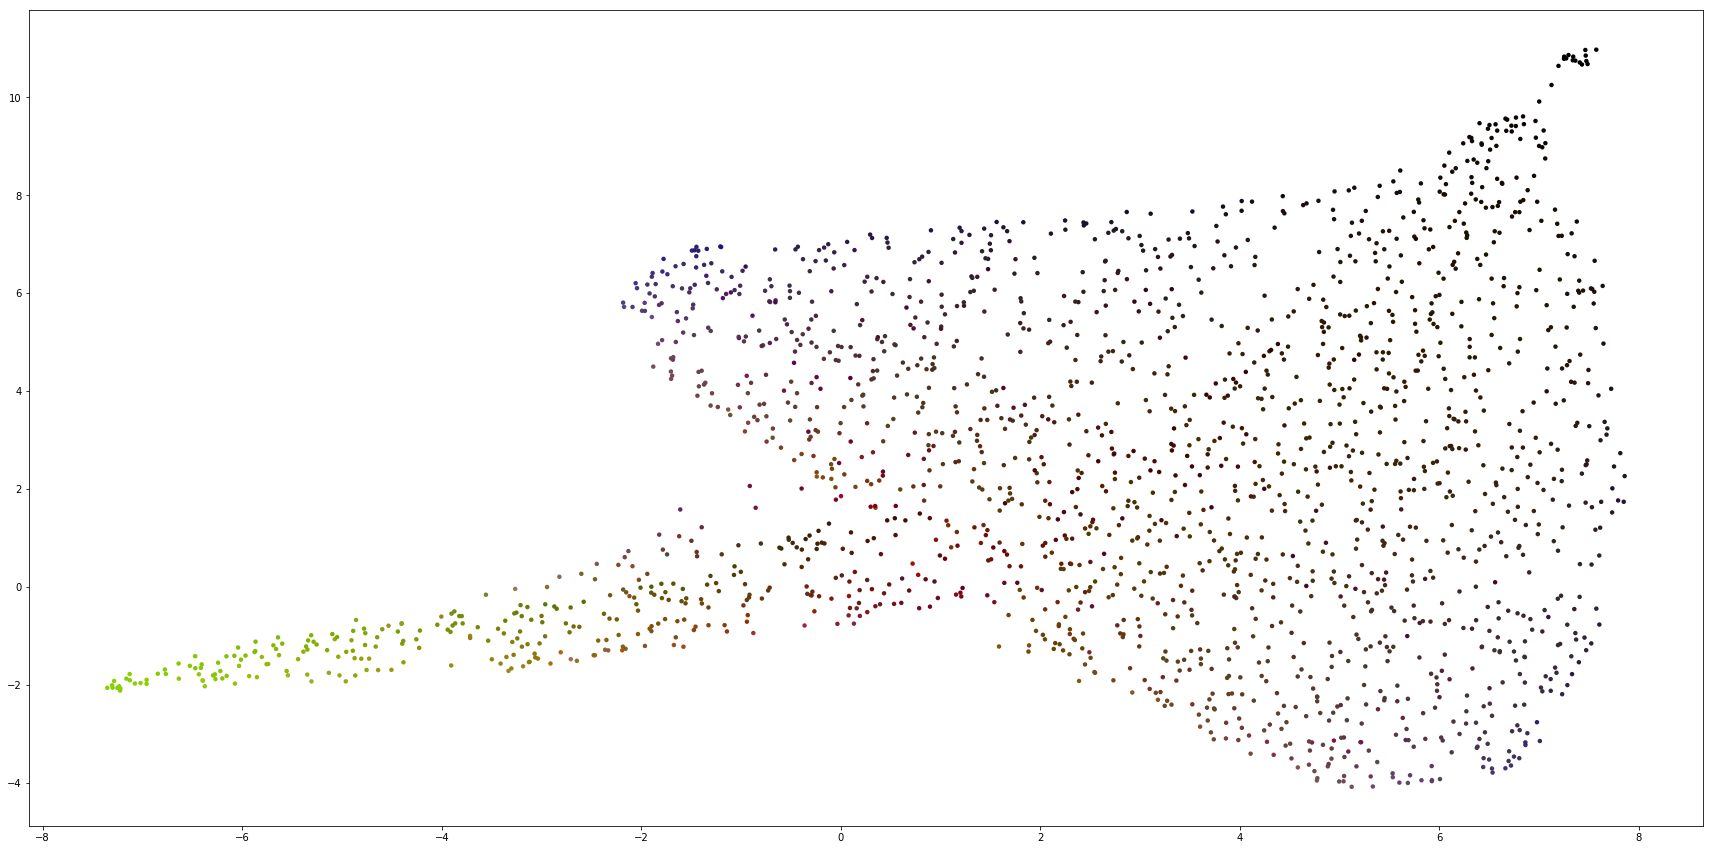

In [28]:
from sklearn.decomposition import TruncatedSVD 
import umap 

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=3, algorithm='randomized', n_iter=100, random_state=122) 
X_topics = svd_model.fit_transform(tfidf_matrix) 
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(X_topics) 

colors = []
for x,y,z in X_topics:
    colors.append((abs(x), abs(y), abs(z)))
    
plt.figure(figsize=(30,15)) 
i = 0;
for em in embedding:
    plt.scatter(em[0], em[1],
        c = colors[i],
        s = 20, # size 
        edgecolor='none' )
    i = i+1
plt.show()

# Create a 2D Visualization

Using PCA, create a 2D Visualizaton of the TF/IDF Matrix.

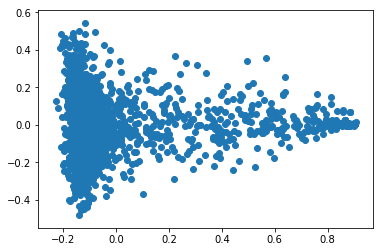

In [29]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

X = tfidf_matrix.todense()

pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1])

plt.show()


# I'll have another

Now try the same thing with MDS for reducing to 2 dimensions.

Wall time: 6min 8s


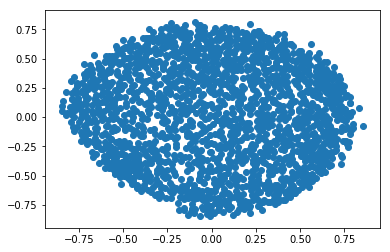

In [31]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

%time pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
plt.scatter(pos[:,0], pos[:,1])

plt.show()
xs, ys = pos[:, 0], pos[:, 1]


# Find Nearest Neighbors

Using the TF/IDF Matrix, find the nearest neighbors for each bug. Print out a random sample with links to spot check. Also plot the distance to the nearest neighbor to visualize the distribution.

Wall time: 15.6 ms
Check the following bugs for relatedness...
https://bugs.eclipse.org/bugs/show_bug.cgi?id=473027
https://bugs.eclipse.org/bugs/show_bug.cgi?id=454267

https://bugs.eclipse.org/bugs/show_bug.cgi?id=519251
https://bugs.eclipse.org/bugs/show_bug.cgi?id=471689

https://bugs.eclipse.org/bugs/show_bug.cgi?id=481698
https://bugs.eclipse.org/bugs/show_bug.cgi?id=461565

https://bugs.eclipse.org/bugs/show_bug.cgi?id=528751
https://bugs.eclipse.org/bugs/show_bug.cgi?id=482978

https://bugs.eclipse.org/bugs/show_bug.cgi?id=406328
https://bugs.eclipse.org/bugs/show_bug.cgi?id=507747

Distanance to nearest neighbor (Mean/StdDev/Min/Max): (0.75/0.22/0.00/1.00) 


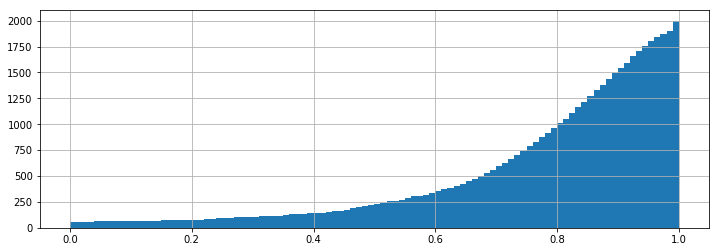

In [32]:
from sklearn.neighbors import NearestNeighbors

%time nbrs = NearestNeighbors().fit(tfidf_matrix)
distances, indices = nbrs.kneighbors(tfidf_matrix)

indicesDF = pd.DataFrame(indices)
sample = indicesDF.sample(5)
print('Check the following bugs for relatedness...')
for row in sample.values:
    print('https://bugs.eclipse.org/bugs/show_bug.cgi?id='+str(bug_ids[row[0]]))
    #print(noun_verb(bug_text[row[0]]))
    print('https://bugs.eclipse.org/bugs/show_bug.cgi?id='+str(bug_ids[row[1]]))
    #print(noun_verb(bug_text[row[1]]))
    print()
distancesDF = pd.DataFrame(distances)

# Slice the distances returned to get the column of the nearest neighbor
nearest = distancesDF.iloc[:, 1]
print('Distanance to nearest neighbor (Mean/StdDev/Min/Max): (%0.2f/%0.2f/%0.2f/%0.2f) ' % (np.mean(nearest), np.std(nearest),
     np.min(nearest), np.max(nearest)))
nearest.hist(cumulative=True, bins=100, figsize=(12, 4));
plt.show()

In [33]:
from sklearn.cluster import KMeans
from sklearn import metrics

num_clusters = 15

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

labels = km.labels_

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(tfidf_matrix, km.labels_, sample_size=1000))



Wall time: 5.27 s
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand-Index: 1.000
Silhouette Coefficient: 0.076


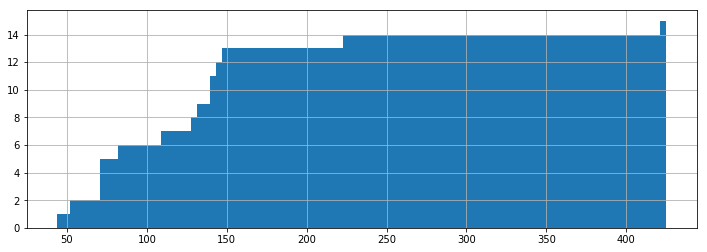

In [34]:
clusters = km.labels_.tolist()
bugs = { 'title': bug_titles, 'text': bug_text, 'cluster': clusters }
frame = pd.DataFrame(bugs, index = [clusters] , columns = ['title', 'cluster'])
frame['cluster'].value_counts().hist(cumulative=True, bins=100, figsize=(12, 4));
plt.show()

In [35]:
print("Top term per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()

top_term = []
for i in range(num_clusters):
    print("Cluster %d:" % i, end='')
    
    for ind in order_centroids[i, :1]:
        print(bug_titles[ind])
        print(terms[ind])
        top_term.append(terms[ind])
        print('https://bugs.eclipse.org/bugs/show_bug.cgi?id='+str(bug_ids[ind]))
        #top_term.append(vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0])
        #print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0])


Top term per cluster:

Cluster 0:[Expansion] Issue on undo /redo when adding a new compartment to a stereotyped element
link
https://bugs.eclipse.org/bugs/show_bug.cgi?id=511394
Cluster 1:[Discovery] CoreException in PrepareInstallProfileJob.resolve
gerrit
https://bugs.eclipse.org/bugs/show_bug.cgi?id=506412
Cluster 2:Labels cut off in diagrams exported as images
bug
https://bugs.eclipse.org/bugs/show_bug.cgi?id=530291
Cluster 3:[SequenceDiagram] Sequence Diagram Not Opened
attachment
https://bugs.eclipse.org/bugs/show_bug.cgi?id=513130
Cluster 4:[ClassDiagram] Missing realization branch capability
element
https://bugs.eclipse.org/bugs/show_bug.cgi?id=468062
Cluster 5:Content of classes drag&droped from imported user model disappears after reopening
stereotype
https://bugs.eclipse.org/bugs/show_bug.cgi?id=460175
Cluster 6:[Profiles] Display in a model of an association defined by a profile
papyrus
https://bugs.eclipse.org/bugs/show_bug.cgi?id=453823
Cluster 7:[ActivityDiagram] Copy-pas

C:\Users\n71583\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


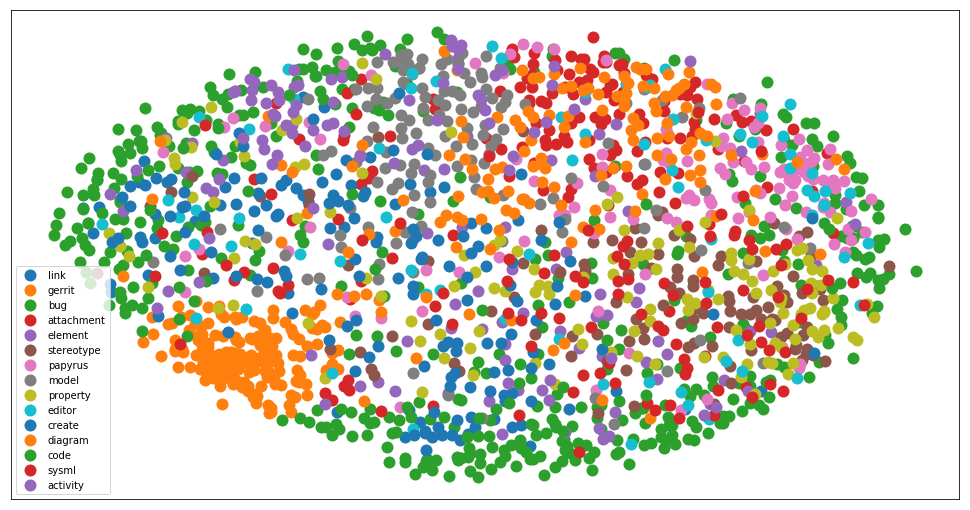

In [36]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=bug_ids)) 

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
#            label=cluster_names[name], color=cluster_colors[name],
#            label=name,
            label=top_term[name],
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the bug id
#for i in range(len(df)):
#    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

plt.show() #show the plot


C:\Users\n71583\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


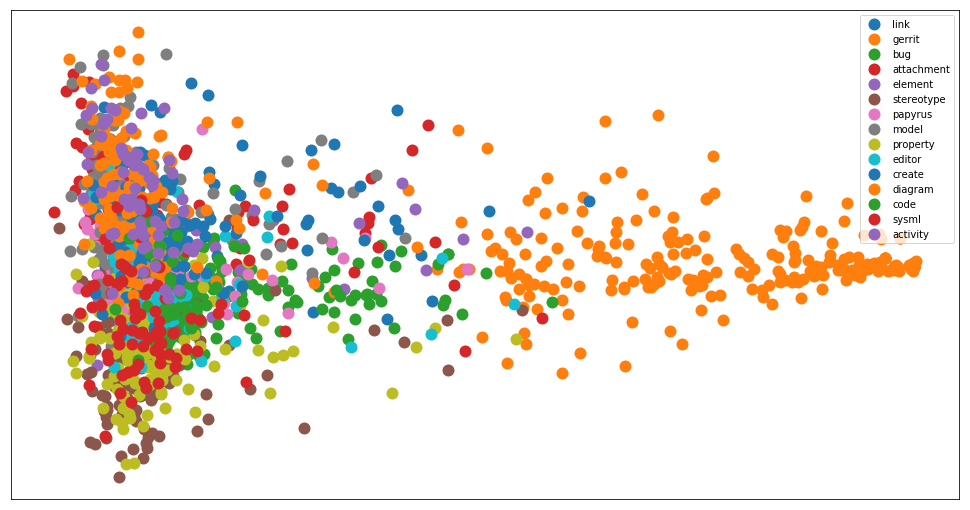

In [37]:
xs, ys = data2D[:, 0], data2D[:, 1]
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=bug_ids)) 

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
#            label=cluster_names[name], color=cluster_colors[name],
#            label=name,
            label=top_term[name],
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the bug id
#for i in range(len(df)):
#    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

plt.show() #show the plot


In [38]:
from sklearn.cluster import DBSCAN

# May be able to calculate this number based on the output from the nearest neighbor search.
# Units relate to the data being fit
epsilon = 0.9


db = DBSCAN(eps=epsilon, min_samples=10)

%time db.fit(tfidf_matrix)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % num_clusters)

Wall time: 216 ms
Estimated number of clusters: 14


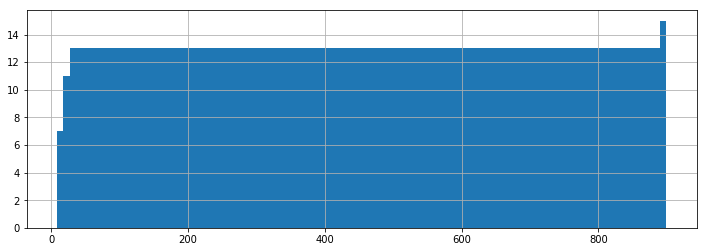

In [39]:
clusters = db.labels_.tolist()
bugs = { 'title': bug_titles, 'text': bug_text, 'cluster': clusters }
frame = pd.DataFrame(bugs, index = [clusters] , columns = ['title', 'cluster'])
frame['cluster'].value_counts().hist(cumulative=True, bins=100, figsize=(12, 4));
plt.show()

C:\Users\n71583\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


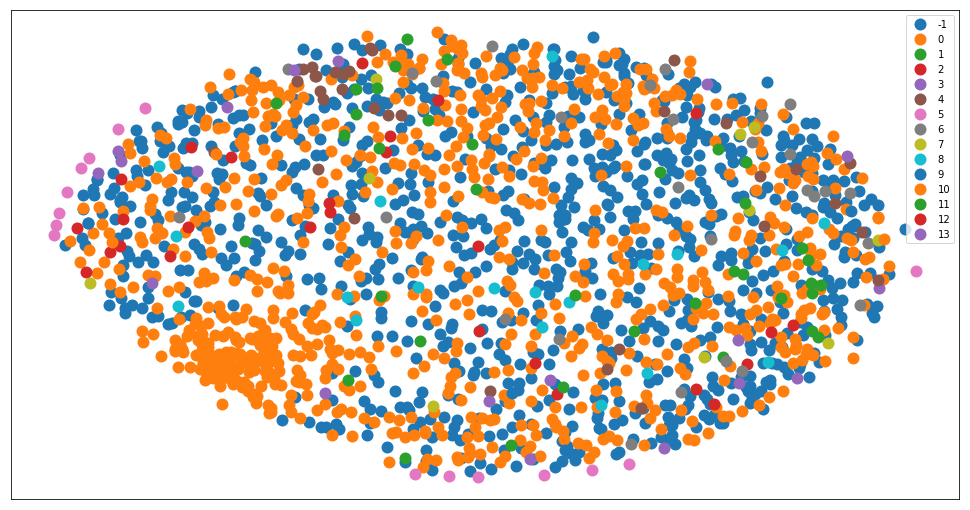

In [40]:
xs, ys = pos[:, 0], pos[:, 1]
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=bug_ids)) 

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
#            label=cluster_names[name], color=cluster_colors[name],
            label=name,
#            label=top_term[name],
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the bug id
#for i in range(len(df)):
#    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

plt.show() #show the plot